In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/final_all_india_cpi.csv", parse_dates=['Date'], index_col='Date')
df.head()


,CPI
Date,
2013-01-01,104.6
2013-02-01,105.3
2013-03-01,105.5
2013-04-01,106.1
2013-05-01,106.9


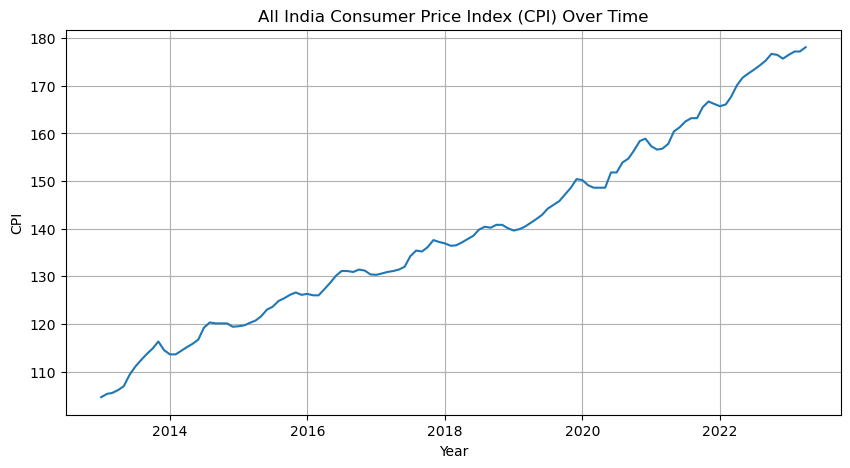

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['CPI'])
plt.title("All India Consumer Price Index (CPI) Over Time")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.grid(True)
plt.show()


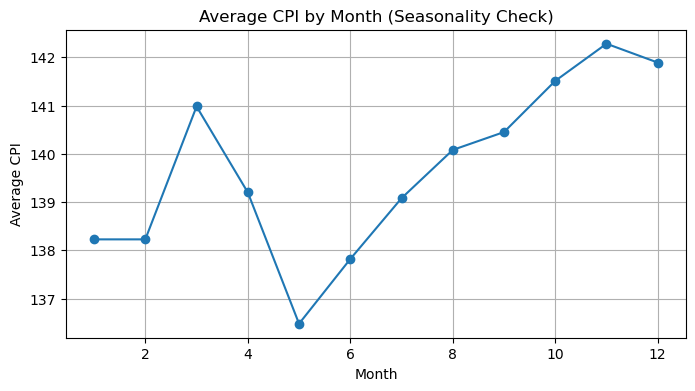

In [3]:
df['Month'] = df.index.month

monthly_avg = df.groupby('Month')['CPI'].mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title("Average CPI by Month (Seasonality Check)")
plt.xlabel("Month")
plt.ylabel("Average CPI")
plt.grid(True)
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['CPI'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: 1.8048290678868428
p-value: 0.998358546800322


In [5]:
df['CPI_diff'] = df['CPI'].diff()


In [6]:
df_diff = df['CPI_diff'].dropna()


In [7]:
adf_result_diff = adfuller(df_diff)

print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])


ADF Statistic (Differenced): -2.724121042222806
p-value (Differenced): 0.06995647190606903


In [8]:
df['CPI_seasonal_diff'] = df['CPI'].diff(12)


In [9]:
df_seasonal = df['CPI_seasonal_diff'].dropna()


In [10]:
from statsmodels.tsa.stattools import adfuller

adf_result_seasonal = adfuller(df_seasonal)

print("ADF Statistic (Seasonal Differenced):", adf_result_seasonal[0])
print("p-value (Seasonal Differenced):", adf_result_seasonal[1])


ADF Statistic (Seasonal Differenced): -0.8090356977183272
p-value (Seasonal Differenced): 0.8164534801576204


In [11]:
df['CPI_diff_combined'] = df['CPI'].diff().diff(12)


In [12]:
df_combined = df['CPI_diff_combined'].dropna()


In [13]:
from statsmodels.tsa.stattools import adfuller

adf_result_combined = adfuller(df_combined)

print("ADF Statistic (Combined Differencing):", adf_result_combined[0])
print("p-value (Combined Differencing):", adf_result_combined[1])


ADF Statistic (Combined Differencing): -4.2135942388311145
p-value (Combined Differencing): 0.0006248441377114028


In [14]:
train = df.iloc[:-12]
test = df.iloc[-12:]


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train['CPI'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit()
print(model_fit.summary())


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -97.645
Date:                            Sat, 14 Feb 2026   AIC                            205.291
Time:                                    13:00:43   BIC                            217.385
Sample:                                         0   HQIC                           210.149
                                            - 110                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0509      0.615     -0.083      0.934      -1.256       1.154
ma.L1          0.2137      0.606   

In [16]:
forecast = model_fit.get_forecast(steps=12)
forecast_values = forecast.predicted_mean


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


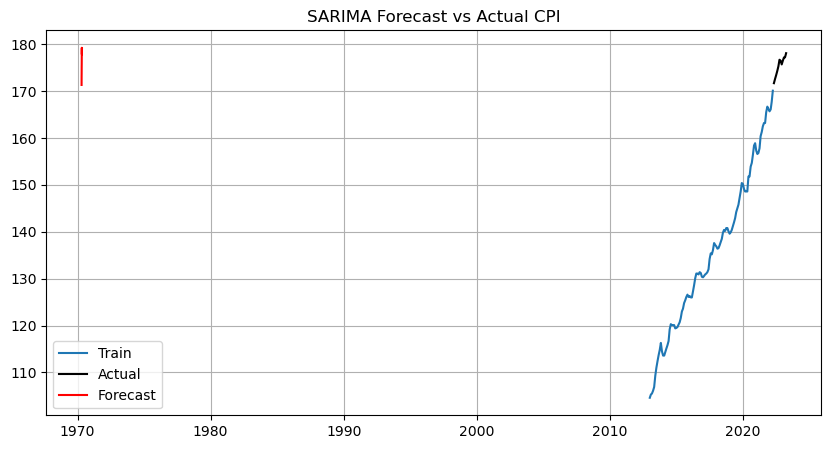

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train['CPI'], label='Train')
plt.plot(test.index, test['CPI'], label='Actual', color='black')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.legend()
plt.title("SARIMA Forecast vs Actual CPI")
plt.grid(True)
plt.show()


In [18]:
# Align forecast index with test data index
forecast_values.index = test.index


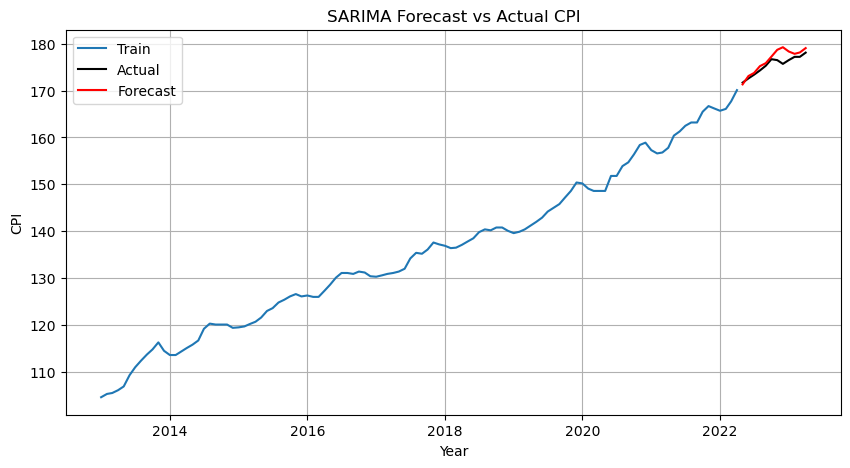

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train['CPI'], label='Train')
plt.plot(test.index, test['CPI'], label='Actual', color='black')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.legend()
plt.title("SARIMA Forecast vs Actual CPI")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['CPI'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['CPI'], forecast_values))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 1.1168882283108132
RMSE: 1.445044093054921


In [21]:
future_forecast = model_fit.get_forecast(steps=12)
future_values = future_forecast.predicted_mean


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=12,
    freq='MS'
)

future_values.index = future_dates


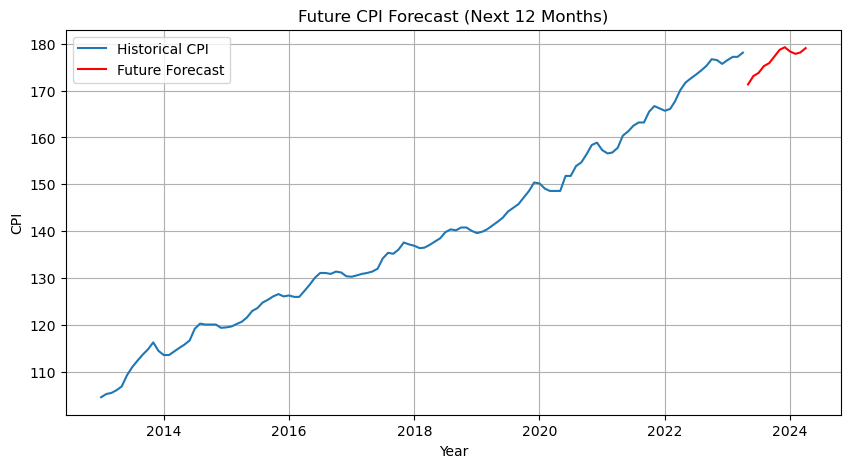

In [23]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['CPI'], label='Historical CPI')
plt.plot(future_values.index, future_values, label='Future Forecast', color='red')
plt.title("Future CPI Forecast (Next 12 Months)")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)
plt.show()
